# Document Summarization

Document summarization refers to the selection of the most important points and topics in a document and arranging them in a comprehensive manner. Analysts at banks and other financial service organizations analyze, and attempt to quantify qualitative data from news, reports, and documents. Document summarization using NLP can provide in-depth support in this analyzing and interpretation. When tailored to financial documents, such as earning reports and financial news, it can help analysts quickly derive key topics and market signals from content. Document summarization can also be used to improve reporting efforts and can provide timely updates on key matters.

In NLP, *topic models* (such as LDA, a  Bayesian network for modeling automatically extracted topics in text) are the most frequently used tools for the extraction of sophisticated, interpretable text features.

The goal of this case study is to effectively discover common topics from earnings call transcripts of publicly traded companies using LDA. A core advantage of this technique compared to other approaches, is that no prior knowledge of the topics is needed.
Each transcript will be assigned to some number of topics, and the specific segments of the transcript which address a given topic will hopefully be specified as well. Thus, not only will the documents be classified as covering some set of topics, but the documents themselves will be partitioned into different sub-topics. 

### Loading the python packages

In the first step we check if the additional packages needed are present, if not install them. These are checked separately as they aren't included in requirement.txt as they aren't used for all case studies. 

For this case study, we will extract the text from a PDF. Hence, the Python library *pdf-miner* is used for processing the PDF files into a text format. Libraries for feature extraction and topic modeling are also loaded.

In [ ]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'pdfminer', 'pyldavis', 'wordcloud','mglearn' }
missing = required - installedPackages
if missing:
    !pip install pdfminer==20191125
    !pip install pyLDAvis==3.4.0
    !pip install wordcloud==1.9.3
    !pip install mglearn==0.2.0

All the libraries for feature extraction and topic modeling are loaded. The libraries for the vizualisation will be loaded later. 

In [ ]:


#Libraries for feature extraction and topic modeling
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

#Other libraries
import numpy as np
import pandas as pd

In [ ]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

## Data Preparation
The function defined below pulls out all characters from a pdf document except the images. The function simply takes in the name of the pdf document, extracts all characters from it and outputs the extracted texts as a python list of strings.

In [ ]:
#Libraries for pdf conversion
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text

The pdf is converted to text using the function defined above.

In [ ]:
Document=convert_pdf_to_txt('./data/summarization/10K.pdf')

In [ ]:
f=open('./data/summarization/Finance10k.txt','w')
f.write(Document)
f.close()

In [7]:
with open('./data/summarization/Finance10k.txt') as f:
    clean_cont = f.read().splitlines()

Let us look at the raw document

In [8]:
clean_cont[1:15]

[' ',
 '',
 'SECURITIES AND EXCHANGE COMMISSION',
 ' ',
 '',
 'Washington, D.C. 20549',
 ' ',
 '',
 '\xa0',
 'FORM ',
 '\xa0',
 '',
 'QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF',
 ' ']

The text extracted from the pdf document contains uninformative characters which needs to be removed. The following function uses a series of regular expression (**regex**) searches as well as list comprehension to replace uninformative characters with a blank space.

In [9]:
import re

doc=[i.replace('\xe2\x80\x9c','') for i in clean_cont ]
doc=[i.replace('\xe2\x80\x9d','') for i in doc ]
doc=[i.replace('\xe2\x80\x99s','') for i in doc ]

docs = [x for x in doc if x != ' ']
docss = [x for x in docs if x != '']
financedoc=[re.sub("[^a-zA-Z]+", " ", s) for s in docss]

In [10]:
financedoc[1:15]

['SECURITIES AND EXCHANGE COMMISSION',
 'Washington D C ',
 ' ',
 'FORM ',
 ' ',
 'QUARTERLY REPORT PURSUANT TO SECTION OR d OF',
 'THE SECURITIES EXCHANGE ACT OF ',
 'For the quarterly period ended September ',
 'Commission file number ',
 ' ',
 ' ',
 'WELLS FARGO COMPANY ',
 ' Exact name of registrant as specified in its charter ',
 'Delaware ']

## Model construction and training

The scikit-learn module CountVectorizer was used with minimal parameter tuning to represent the clean document as a DocumentTermMatrix. This is because modeling requires that strings be represented as integers. The CountVectorizer shows the number of times a word occurs in the list after stop-words were removed.
The document term matrix was formatted into a pandas dataframe to glance the dataset, shown below. This dataframe shows count of word-occurrence of each term in the document. 

In [11]:
from sklearn.feature_extraction.text import CountVectorizer#,TfidfVectorizer
import pandas as pd

vect=CountVectorizer(ngram_range=(1,1),stop_words='english')
fin=vect.fit_transform(financedoc)
pd.DataFrame(fin.toarray(),columns=vect.get_feature_names_out()).head(1)

,aa,aaa,abbot,ability,able,abs,absorb,absorbed,absorbing,abusive,...,years,yes,yield,yielding,yields,york,yrs,zealand,zero,zip
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This document term matrix was used as the input data to be used by the Latent Dirichlet Allocation algorithm for topic modeling. The algorithm was fitted to isolate five-distinct topic contexts as shown by the code below. This value can definitely be altered depending on the level of granularity one intends to obtain from the modeling.

In [12]:
from sklearn.decomposition import LatentDirichletAllocation

lda=LatentDirichletAllocation(n_components=5)
lda.fit_transform(fin)
lda_dtf=lda.fit_transform(fin)

In [13]:
import numpy as np

sorting=np.argsort(lda.components_)[:,::-1]
features=np.array(vect.get_feature_names_out())
print(features)

['aa' 'aaa' 'abbot' ... 'zealand' 'zero' 'zip']


In [14]:
# The following is the code added so that the column names Topic names in mglearn start with 1, 
# if this code is not added the topic names start with 0 and there is misalignment in the topic names 
# from the output of pyLDAvis in the next section. 
array=np.full((1, sorting.shape[1]), 1)
array = np.concatenate((array,sorting), axis=0)

The code below uses the *mglearn* library to display the top 10 words within each specific topic model. One could easily draw conclusions what each topic summarizes from the words presented.

In [15]:
import mglearn

topics = mglearn.tools.print_topics(topics=range(1,6), feature_names=features, 
                                    sorting=array, topics_per_chunk=5, n_words=10)
print(sorting)

topic 1       topic 2       topic 3       topic 4       topic 5       
--------      --------      --------      --------      --------      
million       risk          net           securities    loans         
billion       capital       income        total         assets        
december      management    credit        equity        value         
financial     market        september     debt          mortgage      
respectively  credit        losses        balance       fair          
compared      changes       quarter       backed        total         
quarter       based         rate          millions      commercial    
information   regulatory    months        federal       real          
september     financial     ended         mortgage      estate        
stock         level         gains         loan          liabilities   


[[1787  320  730 ... 2530  654 2865]
 [2528  378 1716 ...  545  678 2865]
 [1869 1432  687 ...  550  678 2865]
 [2583 2898 1020 ...  654 2530  678

Each topic in the table above is expected to represent a broader theme. However, given we trained the model on only on one document the theme within the topics may not be very distinct from each other. Topic-2 discusses quarters, months and  currency units related to asset valuation. Topic-3 talks about income from real estate, mortgage and related instrument. Topic-5 has terms related to asset valuation. Topic-1 has much to do with balance sheet items. Topic-4 is slighly similar to Topic-1 and has words related to instruments and markets. 

In terms of overall theme, topic 2 and topic 5 are quite distinct from others. There might be some similarity between topics 1 and 4 from the words we see under these topics. In the next section we will try to understand the separation between these topics using the python library pyLDAvis.

## Topics Visualization

Topic visualization facilitates the evaluation of topic quality using human judgment.
pyLDAvis is library that displays the global relationships between topics while also facilitating their
semantic evaluation by inspecting the terms most closely associated with each topic and,
inversely, the topics associated with each term. It also addresses the challenge that terms
that are frequent in a corpus tend to dominate the multinomial distribution over words that
define a topic. The PyldaVis library was used to visualize the topic models. 

In [ ]:
from __future__ import  print_function
import pyLDAvis.lda_model

**It do not work with pandas >2.0.0 so I could not reproduce this code**

In [ ]:
zit=pyLDAvis.lda_model.prepare(lda,fin,vect)

In [ ]:
pyLDAvis.display(zit)

The display used for the purpose of the book is shown below. 

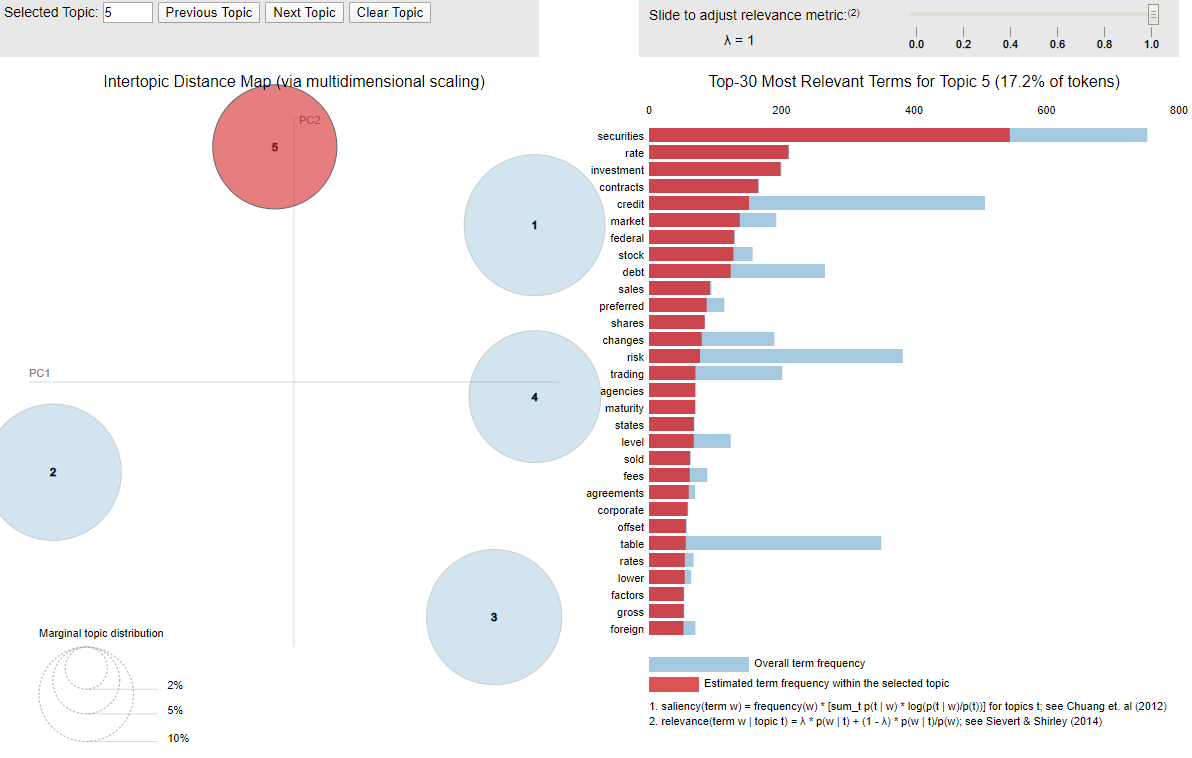

We notice that topic 2 and topic 5 are quite distant from each other. This is what we observed in the section above from the words and overall theme of these topics. However, topics 1 and 4 quite close as we observed before. These topics should be analyzed more intricately as they might be combined if needed to have clear separation of the topics. The relevance of the terms under each topic as shown in the right panel of the chart above can also be used to understand the differences. Topics 3 and 4 are relatively closer as well, although 3 is quite distant from other topics.

## WordCloud
A wordcloud was also generated for the entire legal document to note the most recurrent terms in the document as shown in the figure below. 

In [1]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS

In [2]:
d = path.dirname(__name__)

In [3]:
text = open(path.join(d, './data/summarization/Finance10k.txt')).read()

In [4]:
#raw_pic = np.array(Image.open(path.join(d, "legalpic.png")))

In [5]:
stopwords = set(STOPWORDS)
wc = WordCloud(background_color="black", max_words=2000, stopwords=stopwords)
wc.generate(text)

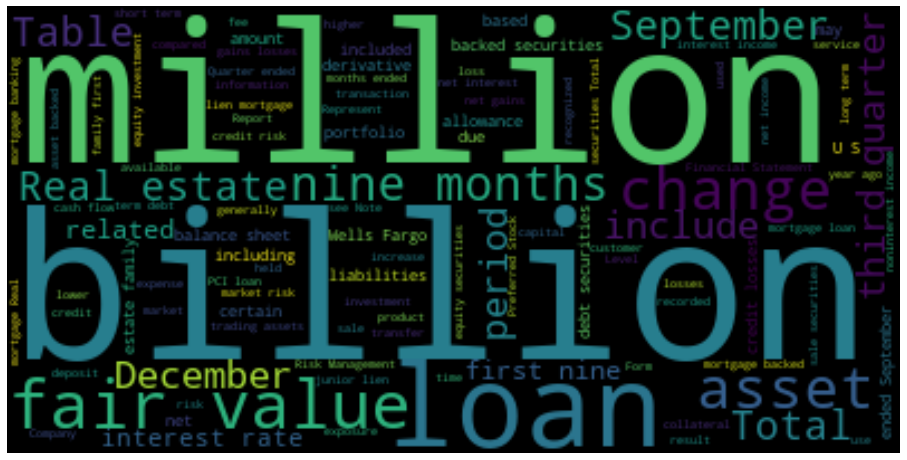

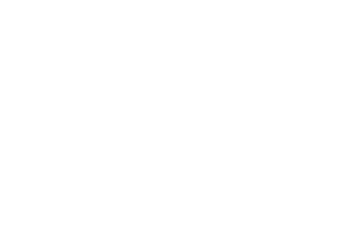

In [6]:
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
#plt.imshow(raw_pic, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

The word cloud generally agrees with the results from the topic modeling as words like : LOAN,REAL ESTATE, NINE MONTHS,FAIR VALUE, MILLION etc are seen to be recurrent and hence bolder .

By integrating Topics’s 1, 3 and 4 obtained by the Latent Dirichlet Allocation modeling with the Word Cloud generated for the finance document, we can safely deduce that this document is a simple Third Quarter Financial Balance sheet with all credit and assets values in that quarter with respect to all assets values.